## **Twitter Sentiment Analysis** 
## **Usecase: PiggyVest**

### Overview
This notebook extracts and analyzes sentiment in tweets about PiggyVest using Natural Language Processing. The analysis involves data preprocessing, sentiment analysis using pre-trained models, and comparison of results between raw and cleaned data. The notebook is structured as follows:
1. Data Import and Initial Inspection
2. Data Preprocessing
3. Sentiment Analysis
4. Results and Evaluation

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import ipywidgets as widgets
from IPython.display import display
# import librabries
import snowflake.connector
import getpass

import warnings
warnings.filterwarnings('ignore')

In [ ]:
nlp = spacy.load('en_core_web_lg')

### **DATA IMPORT AND INITIAL INSPECTION**
Let's start by collecting our data from the Snowflake warehouse, then understanding the structure and size of the dataset. We'll look at the first few rows and check the dimensions to get an idea of what we're working with.


In [ ]:
# Prompt for to enter secrets securely
user = getpass.getpass(prompt='Enter your Snowflake username: ')
password = getpass.getpass(prompt='Enter your Snowflake password: ')

In [2]:
# Establish the connection using the masked password
ctx = snowflake.connector.connect(
    user=user,
    password=password,
    account='hi37226.eu-north-1.aws',
    warehouse='sentiment_warehouse',
    database='sentiment_database',
    schema='sentiment_schema'
)

In [ ]:
# Create a cursor object
cur = ctx.cursor()

In [ ]:
# Execute a query
cur.execute("SELECT * FROM sentiment_database.sentiment_schema.dim_tweets")

In [154]:
# Fetch and print the result
tweets = cur.fetch_pandas_all()
data = tweets.copy()

In [155]:
data.head()

,TWEET_ID,USER_ID,CREATED_AT,TEXT,URL,MENTIONS,LANG,FAVOURITES,RETWEETS,REPLIES,QUOTES,VIEW_COUNT,HASHTAGS
0,1819681803604508810,886083200,2024-08-03 10:28:44.000 Z,Piggyvest is a life saver. I'm introducing thi...,NaN,NaN,en,7,2,5,0,1715.0,NaN
1,1819477474595545568,1761141472781279232,2024-08-02 20:56:48.000 Z,PiggyVest go think say I don die,https://t.co/rME1dNHNjK,NaN,en,3,0,1,0,47.0,NaN
2,1819379501471535188,1249897379207286784,2024-08-02 14:27:30.000 Z,Use piggyvest bros,NaN,NaN,lt,1,0,1,1,14263.0,NaN
3,1819764467078508980,1759572460301672448,2024-08-03 15:57:13.000 Z,Piggyvest needs to stop me from withdrawing,NaN,NaN,en,1,0,1,0,66.0,NaN
4,1819440896863281310,1081875638573809664,2024-08-02 18:31:28.000 Z,My female friend sent me a screenshot of her s...,NaN,NaN,en,56,22,10,0,2969.0,NaN


In [156]:
data.shape

(1332, 13)

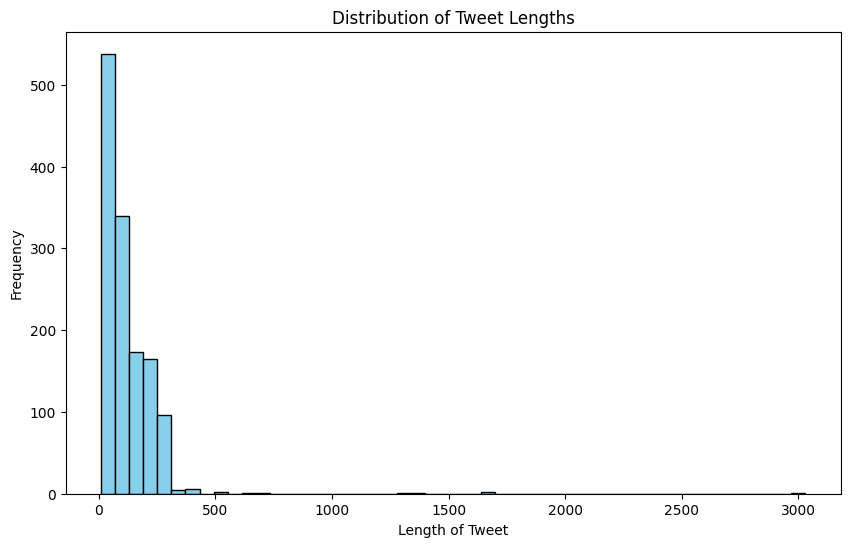

In [157]:
# Visualizing the distribution of tweet lengths
tweet_lengths = data['TEXT'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

> More than 90% of the tweets have contain less than 500 characters, which is suitable for the model to handle

### **DATA PREPROCESSING**
Text data often contains noise such as special characters, links, and stopwords. This section outlines the preprocessing steps applied to clean the text data before sentiment analysis.

In [6]:
def preprocess(text):
    """
    Preprocesses the input text by removing special characters and stopwords.
    
    Parameters:
    text (str): The raw tweet text.

    Returns:
    str: The cleaned, preprocessed text.
    """
    preprocessed_text = []
    doc = nlp(text) 
    for i in doc:
        if i.is_stop or i.is_punct:
            continue
        preprocessed_text.append(i.lemma_.lower())
        
    return ' '.join(preprocessed_text)
    

In [158]:
data['PREPROCESSED_TEXT'] = data['TEXT'].apply(preprocess)

In [17]:
data[['TEXT', 'PREPROCESSED_TEXT']]

,TEXT,PREPROCESSED_TEXT
0,Piggyvest is a life saver. I'm introducing thi...,piggyvest life saver introduce friend
1,PiggyVest go think say I don die,piggyvest think don die
2,Use piggyvest bros,use piggyvest bro
3,Piggyvest needs to stop me from withdrawing,piggyvest need stop withdraw
4,My female friend sent me a screenshot of her s...,female friend send screenshot saving jollof ...
...,...,...
1327,"To Piggyvests dpo, your privacy policy has som...",piggyvests dpo privacy policy gap patent one i...
1328,"Any 10k you see this period, hold an tight Loc...",10k period hold tight lock papa piggyvest blin...
1329,"Nigerian woman math. GTB N2,430. 53 PIGGYVES...","nigerian woman math gtb n2,430 53 piggyves..."
1330,I wish piggyvest can find a solution to breaki...,wish piggyv find solution break locked fund ne...


### **SENTIMENT ANALYSIS**
We will use a pre-trained transformer model to classify the sentiment of each tweet. The model is fine-tuned for sentiment analysis and will categorize tweets into positive, negative, or neutral sentiments.


In [25]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm

In [10]:
model_path = r"C:\Users\HP\Documents\projects\Sentiment Analysis\model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at C:\Users\HP\Documents\projects\Sentiment Analysis\model were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a

In [22]:
def analyze(text, padding='max_length', max_length=514):    
    encode_text = tokenizer(text, return_tensors='pt')
    output = model(**encode_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'Negative' : scores[0],
        'Neutral' : scores[1],
        'Positive' : scores[2]
    }
    max_key = max(scores_dict, key=scores_dict.get)
    
    return max_key

#### **Sentiment Analysis on Raw Data**
In this section, we'll analyze the sentiment of the raw, unprocessed tweets to understand the initial distribution of sentiments.


In [27]:
sentiment = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['TEXT']
        myid = row['TWEET_ID']
        sentiment[myid] = analyze(text)
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1332 [00:00<?, ?it/s]

Broke for id 1716344701098307784


In [126]:
records = [(k, v) for k, v in sentiment.items()]
raw_sentiment_df = pd.DataFrame.from_records(records)
raw_sentiment_df.rename(columns={0:'TWEET_ID', 1:'RAW SENTIMENT'}, inplace=True)

In [127]:
raw_sentiment_df.head()

,TWEET_ID,RAW SENTIMENT
0,1819681803604508810,Positive
1,1819477474595545568,Neutral
2,1819379501471535188,Neutral
3,1819764467078508980,Negative
4,1819440896863281310,Neutral


In [129]:
raw_sentiment_df['RAW SENTIMENT'].value_counts()

Neutral     731
Positive    345
Negative    255
Name: RAW SENTIMENT, dtype: int64

#### **Sentiment Analysis on Cleaned Data**
Now, we'll analyze the sentiment of the preprocessed tweets. This analysis helps us understand the impact of data cleaning on sentiment classification.


In [64]:
cleaned_sentiment = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['PREPROCESSED_TEXT']
        myid = row['TWEET_ID']
        cleaned_sentiment[myid] = analyze(text)
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1332 [00:00<?, ?it/s]

In [130]:
cleaned_sentiment_df = pd.DataFrame.from_records([(k, v) for k, v in cleaned_sentiment.items()])
cleaned_sentiment_df.rename(columns={0:'TWEET_ID', 1:'CLEANED SENTIMENT'}, inplace=True)

In [132]:
cleaned_sentiment_df.head()

,TWEET_ID,CLEANED SENTIMENT
0,1819681803604508810,Neutral
1,1819477474595545568,Neutral
2,1819379501471535188,Neutral
3,1819764467078508980,Negative
4,1819440896863281310,Neutral


In [131]:
cleaned_sentiment_df['CLEANED SENTIMENT'].value_counts()

Neutral     1004
Positive     190
Negative     138
Name: CLEANED SENTIMENT, dtype: int64

### **RESULTS AND EVALUATION**
Finally, we'll compare the performance of the sentiment analysis on the raw vs. cleaned data using classification metrics. This will help us evaluate the effectiveness of the preprocessing steps.


In [159]:
# merging the various sentiment datasets into one
classified_tweets = tweets.merge(raw_sentiment_df, how='left')
classified_tweets = classified_tweets.merge(cleaned_sentiment_df, how='left')

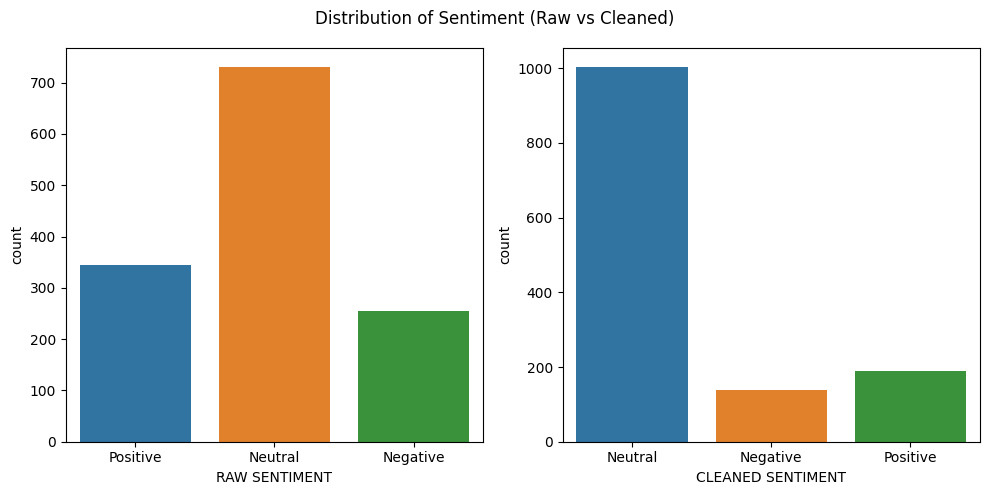

In [137]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(classified_tweets['RAW SENTIMENT'], ax=ax[0])
sns.countplot(classified_tweets['CLEANED SENTIMENT'], ax=ax[1])
fig.suptitle('Distribution of Sentiment (Raw vs Cleaned)')
plt.tight_layout()

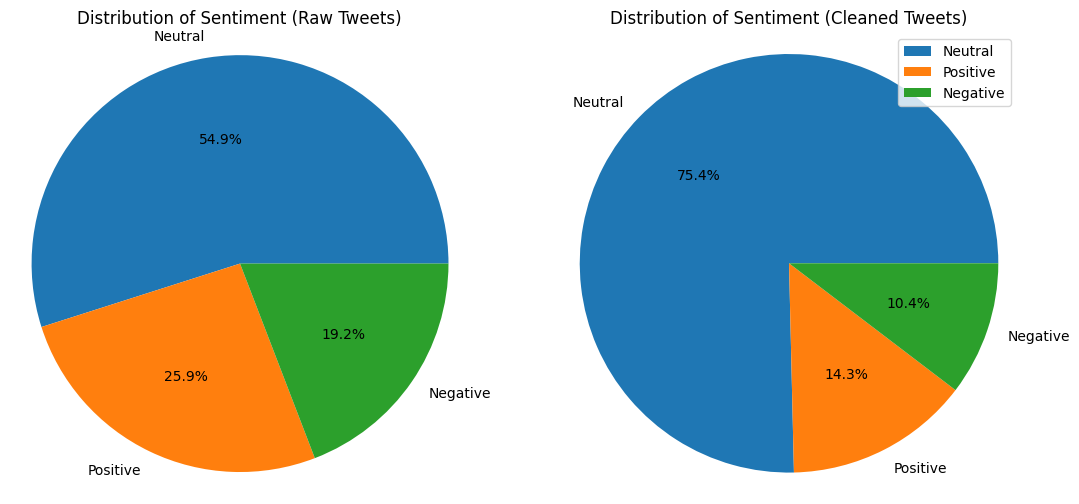

In [153]:
fig, ax = plt.subplots(1,2, figsize=(13,6))

ax[0].pie(classified_tweets['RAW SENTIMENT'].value_counts(),labels=classified_tweets['RAW SENTIMENT'].value_counts().index,
        autopct='%1.1f%%')
ax[0].axis('equal')
ax[0].set_title('Distribution of Sentiment (Raw Tweets)')


ax[1].pie(classified_tweets['CLEANED SENTIMENT'].value_counts(),labels=classified_tweets['CLEANED SENTIMENT'].value_counts().index,
        autopct='%1.1f%%')
ax[1].axis('equal')
ax[1].set_title('Distribution of Sentiment (Cleaned Tweets)')
plt.legend()

In [138]:
# saving the dataset to manually compare the correctness of the sentiment
sample_tweets = classified_tweets[['TWEET_ID', 'TEXT', 'PREPROCESSED_TEXT', 'RAW SENTIMENT', 'CLEANED SENTIMENT']]
sample_tweets.to_csv('sample_tweets.csv', index=False)

filter through the dataset to compare the sentiments manually

In [140]:
sentiment_dropdown = widgets.Dropdown(
    options=['All', 'Positive', 'Negative', 'Neutral'],
    value='All',
    description='Filter datset by sentiment:',
    disabled=False,
)

def filter_tweets_by_sentiment(sentiment):
    if sentiment == 'All':
        filtered_data = sample_tweets
    else:
        filtered_data = sample_tweets[sample_tweets['RAW SENTIMENT'] == sentiment]
    
    # Display the filtered data (or a sample)
    display(filtered_data.head(10))
    

widgets.interact(filter_tweets_by_sentiment, sentiment=sentiment_dropdown)

# Display the widget
display(sentiment_dropdown)

interactive(children=(Dropdown(description='Filter datset by sentiment:', options=('All', 'Positive', 'Negativ…

Dropdown(description='Filter datset by sentiment:', options=('All', 'Positive', 'Negative', 'Neutral'), value=…

### **OUTPUT DATASET**
The output dataset contains two new columns - **[RAW SENTIMENT and CLEANED SENTIMENT]** added to the original dataset. The values in these columns are typically categorized as Positive, Negative, or Neutral, depending on the model's prediction on the raw and preprocessed tweets respectively

In [161]:
classified_tweets.to_csv('classified_tweets.csv', index=False)